In [45]:
from rlr_validate_custom import rlr_validate_custom
from sklearn import model_selection
from ann_validate import ann_validate
import torch
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from scipy.stats import zscore

url = "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data"

# Load the SAheart dataset
df = pd.read_csv(url, index_col='row.names')

# Convert binary text data to numbered categories
df['famhist'] = pd.Categorical(df['famhist']).codes

# Extract the target attribute, and remove it from the training data
y = np.asarray(np.asmatrix(df["typea"].values).T).squeeze()
df = df.drop(columns=["typea"])

# Attribute names
attributeNames = list(map(lambda x: x.capitalize(), df.columns.tolist()))

# Convert the training data to a numpy array
X = df.to_numpy()
N, M = X.shape

X = zscore(X, ddof=1)  # Mean = 0, Std = 1
y = zscore(y, ddof=1)  # Mean = 0, Std = 1

# ---
# End of data loading
# ---


# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

lambda_count = 20

# Values of lambda
lambdas = np.logspace(0, 4, lambda_count)
n_hidden_units_range = range(1, 30)
max_iter = 10000

#Actual y-s
y_true = []

# Linear regression
lr_error_train = np.empty((K, 1))
lr_error_test = np.empty((K, 1))
best_lambda = np.empty((K, 1))
y_est_lr = []

# ANN
ann_error_train = np.empty((K, 1))
ann_error_test = np.empty((K, 1))
best_hidden_units = np.empty((K, 1))
y_est_ann = []

# Baseline
baseline_error_test = np.empty((K, 1))
y_est_base = []


w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    innerCV = model_selection.KFold(K, shuffle=True)

    y_true.append(y_test)


    # ----
    # Linear regression
    # ----

    (   opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate_custom(X_train, y_train, lambdas, K, innerCV)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    lr_error_train[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    lr_error_test[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )
    best_lambda[k] = opt_lambda
    y_est_lr.append(X_test @ w_rlr[:, k])

    # ----
    # ANN
    # ----

    loss_fn = torch.nn.MSELoss()
    models = np.empty((len(n_hidden_units_range),), dtype=object)

    # Generate out models with different number of hidden units
    for i, n_hidden_units in enumerate(n_hidden_units_range):
        model = torch.nn.Sequential(
            torch.nn.Linear(M, n_hidden_units),  # Input layer
            torch.nn.Tanh(),  # Hidden activation (ReLU is also good)
            torch.nn.Linear(n_hidden_units, 1)   # Output layer (NO SIGMOID for regression)
        )
        models[i] = model

    (
        opt_val_err,
        opt_model_index,
        opt_model,
        opt_network,
        train_err_vs_lambda,
        test_err_vs_lambda
        #This does a folding cross-validation
    ) = ann_validate(torch.Tensor(X_train), torch.Tensor(y_train), models, loss_fn, 1, max_iter, K, innerCV)

    #ann_error_train[k] = np.square(y_train-opt_network(torch.Tensor(X_train)).detach().numpy()).sum()/y_train.shape[0]
    #ann_error_test[k] = np.square(y_train-opt_network(torch.Tensor(X_train)).detach().numpy()).sum()/y_train.shape[0]

    ann_error_train[k] = train_err_vs_lambda[opt_model_index]
    ann_error_test[k] = test_err_vs_lambda[opt_model_index]
    best_hidden_units[k] = n_hidden_units_range[opt_model_index]
    y_est_ann.append(opt_network(torch.Tensor(X_test)).detach().numpy())

    # ----
    # Baseline
    # ----

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Compute the mean of y_train as the baseline prediction
    y_baseline = np.mean(y_train)

    # Predict the same mean value for all test samples
    y_pred_baseline = np.full_like(y_test, y_baseline)

    # Compute and store the MSE
    mse = mean_squared_error(y_test, y_pred_baseline)
    baseline_error_test[k] = mse
    y_est_base.append(y_pred_baseline)


    k += 1


[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([373])) that is different to the input size (torch.Size([373, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
5it [00:46,  9.25s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([373])) that is different to the input size (torch.Size([373, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
5it [00:44,  9.23s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:54,  8.97s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:53,  9.02s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:56,  9.40s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:57,  9.10s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:49,  8.46s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:49,  8.27s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:51,  8.55s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

[Sequential(
   (0): Linear(in_features=10, out_features=1, bias=True)
   (1): Tanh()
   (2): Linear(in_features=1, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=2, bias=True)
   (1): Tanh()
   (2): Linear(in_features=2, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=3, bias=True)
   (1): Tanh()
   (2): Linear(in_features=3, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=4, bias=True)
   (1): Tanh()
   (2): Linear(in_features=4, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=5, bias=True)
   (1): Tanh()
   (2): Linear(in_features=5, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=6, bias=True)
   (1): Tanh()
   (2): Linear(in_features=6, out_features=1, bias=True)
 )
 Sequential(
   (0): Linear(in_features=10, out_features=7, bias=True)
   (1): Tanh()
   (2): Linear(in_features=7, out_feat

0it [00:00, ?it/s]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([374])) that is different to the input size (torch.Size([374, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/ann_validate.py:241: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:
6it [00:48,  8.32s/it]/Users/kostyalbalint/Documents/Egyetem/MSC/1.st Semester/IntroductionToMachineLearning/Intro-to-MI-Project_1/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([375])) that is different to the input size (torch.Size([375, 1])). This will li

In [46]:
results = pd.DataFrame({
    "h" : best_hidden_units.flatten(),
    "ann_error_test": ann_error_test.flatten(),

    "lambda": best_lambda.flatten(),
    "lr_error_test": lr_error_test.flatten(),

    "baseline_error_test": baseline_error_test.flatten(),
})
results

,h,ann_error_test,lambda,lr_error_test,baseline_error_test
0,9.0,0.981690,78.475997,1.095045,1.111682
1,20.0,0.997443,78.475997,1.014643,0.998448
2,5.0,1.024234,127.427499,0.739055,0.748277
3,6.0,1.000396,29.763514,0.988991,0.948298
4,17.0,0.991316,78.475997,0.990541,1.057561
5,23.0,0.988164,127.427499,1.026781,1.053704
6,13.0,1.000706,335.981829,0.890256,0.917386
7,10.0,0.977799,127.427499,1.140282,1.186476
8,14.0,0.982276,78.475997,1.100426,1.172839
9,11.0,1.013012,78.475997,0.790712,0.838251


In [48]:
latex_table = r"""\begin{tabular}{c|cc|cc|c}
\toprule
\textbf{Outer fold} & \multicolumn{2}{c|}{\textbf{ANN}} & \multicolumn{2}{c|}{\textbf{Linear regression}} & \textbf{baseline} \\
$i$ & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
"""

for i, row in results.iterrows():
    latex_table += f"{i+1} & {row['h']} & {row['ann_error_test']:.3f} & {row['lambda']:.2f} & {row['lr_error_test']:.3f} & {row['baseline_error_test']:.3f} \\\\\n"

latex_table += r"\bottomrule" + "\n" + r"\end{tabular}"
print(latex_table)


\begin{tabular}{c|cc|cc|c}
\toprule
\textbf{Outer fold} & \multicolumn{2}{c|}{\textbf{ANN}} & \multicolumn{2}{c|}{\textbf{Linear regression}} & \textbf{baseline} \\
$i$ & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
1 & 9.0 & 0.982 & 78.48 & 1.095 & 1.112 \\
2 & 20.0 & 0.997 & 78.48 & 1.015 & 0.998 \\
3 & 5.0 & 1.024 & 127.43 & 0.739 & 0.748 \\
4 & 6.0 & 1.000 & 29.76 & 0.989 & 0.948 \\
5 & 17.0 & 0.991 & 78.48 & 0.991 & 1.058 \\
6 & 23.0 & 0.988 & 127.43 & 1.027 & 1.054 \\
7 & 13.0 & 1.001 & 335.98 & 0.890 & 0.917 \\
8 & 10.0 & 0.978 & 127.43 & 1.140 & 1.186 \\
9 & 14.0 & 0.982 & 78.48 & 1.100 & 1.173 \\
10 & 11.0 & 1.013 & 78.48 & 0.791 & 0.838 \\
\bottomrule
\end{tabular}


In [51]:
from dtuimldmtools.statistics.statistics import ttest_twomodels
import numpy as np

# Compute the Jeffreys interval
alpha = 0.05
rho = 1/K

# Convert lists to numpy arrays and stack them properly
y_true_array = np.concatenate(y_true).ravel()
y_est_ANN_array = np.concatenate(y_est_ann).ravel()
y_est_LR_array = np.concatenate(y_est_lr).ravel()
y_est_base_array = np.concatenate(y_est_base).ravel()

def run_ttest(y_true, y_A, y_B):
    mean_diff, confidence_interval, p_value =  ttest_twomodels(y_true, y_A, y_B, alpha=alpha)
    return mean_diff, confidence_interval, p_value

# Perform t-tests
mean_diff_ANN_LR, CI_ANN_LR, p_ANN_LR = run_ttest(y_true_array, y_est_ANN_array, y_est_LR_array)
mean_diff_ANN_base, CI_ANN_base, p_ANN_base = run_ttest(y_true_array, y_est_ANN_array, y_est_base_array)
mean_diff_LR_base, CI_LR_base, p_LR_base = run_ttest(y_true_array, y_est_LR_array, y_est_base_array)

results_df = pd.DataFrame({
    "Comparison": ["ANN vs LR", "ANN vs Baseline", "LR vs Baseline"],
    "Mean Difference": [mean_diff_ANN_LR, mean_diff_ANN_base, mean_diff_LR_base],
    "Confidence Interval Min": [CI_ANN_LR[0], CI_ANN_base[0], CI_LR_base[0]],
    "Confidence Interval Max": [CI_ANN_LR[1], CI_ANN_base[1], CI_LR_base[1]],
    "p-value": [p_ANN_LR, p_ANN_base, p_LR_base]
})

In [52]:
print(results_df.to_latex())

\begin{tabular}{llrrrr}
\toprule
 & Comparison & Mean Difference & Confidence Interval Min & Confidence Interval Max & p-value \\
\midrule
0 & ANN vs LR & 0.011330 & -0.005091 & 0.027750 & 0.175793 \\
1 & ANN vs Baseline & 0.003649 & -0.000059 & 0.007357 & 0.053741 \\
2 & LR vs Baseline & -0.007681 & -0.023887 & 0.008526 & 0.352174 \\
\bottomrule
\end{tabular}



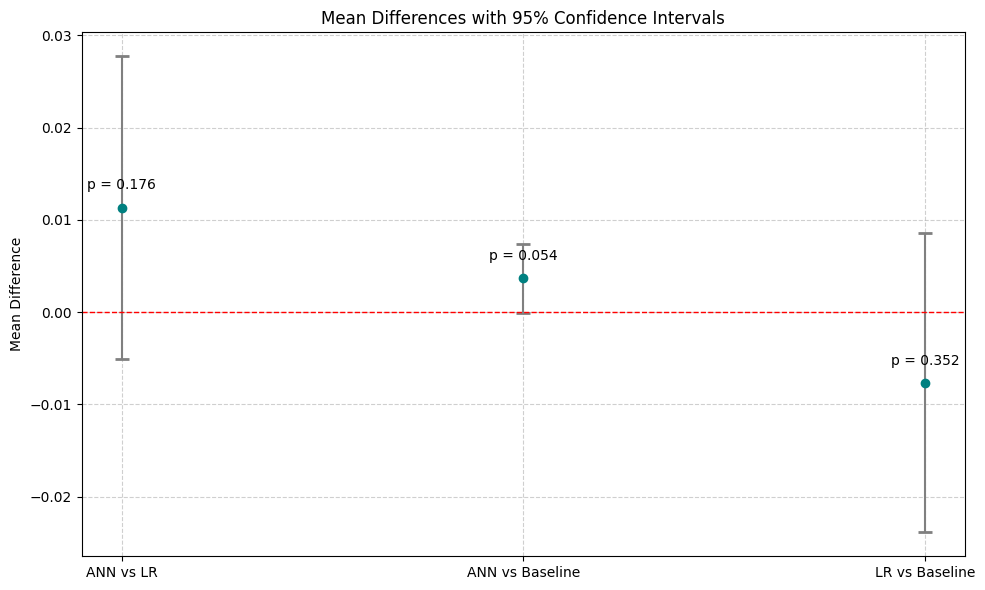

In [60]:
import matplotlib.pyplot as plt
import pandas as pd


# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["Comparison"], results_df["Mean Difference"],
             yerr=[results_df["Mean Difference"] - results_df["Confidence Interval Min"], results_df["Confidence Interval Max"] - results_df["Mean Difference"]],
             fmt='o', capsize=5, capthick=2, color='teal', ecolor='gray')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Mean Differences with 95% Confidence Intervals")
plt.ylabel("Mean Difference")
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate p-values
for i, row in results_df.iterrows():
    plt.text(i, row["Mean Difference"] + 0.002, f"p = {row['p-value']:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()
